# Relative Binding Free Energy (RBFE) Network Tutorial - Analysis

This Jupyter notebook is a tutorial on an analysis workflow for RBFE calculations using a Free Energy Perturbation (FEP) network with BioSimSpace.    

This notebook includes core as well as <span style="color:teal">extra</span> options. These extra sections are there to include some more functionality for when the concepts of these tutorials are applied to your own work.  
**<span style="color:teal">Reading Time:</span>**
~ 30 mins

### Maintainers
- [Anna Herz -- @annamherz](https://github.com/annamherz)

See [README.md](https://github.com/michellab/BioSimSpaceTutorials/blob/main/04_fep/README.md) for complete list of authors.

### Prerequisites
 - Basic Python
 - Part 1 of this workshop (An Introduction to setting up alchemical free energy calculations)
    - this should include basic knowledge of the principles behind RBFE
 - The 01_setup_rbfe notebook

### Learning Objectives
 - Analyse and plot the results of an FEP pipeline setup using BSS.

### Table of Contents
1. [Analysing the edges of the Network](#intro)    
    1.1 [Analysing repeats](#reps)     
    1.2 [Experimental binding affinities](#exp)      
    1.3 [Plotting](#plot)      
2. [Analysing per Ligand](#lig)   
    2.1 [Freenrgworkflows](#fwf)     
    2.2 [Plotting](#plot2)    
    2.3 [Statistical analysis](#stats)     
    2.4 [Outliers](#outliers)  

### Further reading for this topic
- [LiveComs Best Practices for Alchemical Free Energy Calculations](https://livecomsjournal.org/index.php/livecoms/article/view/v2i1e18378).

**<span style="color:black">Jupyter Cheat Sheet</span>**
- To run the currently highlighted cell and move focus to the next cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- To run the currently highlighted cell and keep focus in the same cell, hold <kbd>&#x21E7; ctrl</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- To get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- You can find the full documentation at [biosimspace.org](https://biosimspace.org).

You can use `!` to access terminal commands: e.g. `! head -n 20 myfilename.dat` will display the first 20 lines of a file. 


### Exercises
Exercises are announced using an alert alert-success box in this way:
<div class="alert alert-success">
<b>Exercise 1.1: Write a function that computes bond lengths:</b>
</div>
and followed by an incomplete cell. All exercises should be numbered. 
Missing parts are indicated by:

```python
#FIXME
```
These are included whilst running through the workshops and also in dedicated sections.   


In [1]:
# import libraries
import BioSimSpace as BSS
import os
import glob
import csv
import sys
import numpy as np
import math
import pandas as pd
import networkx as nx
from scipy.stats import sem as sem

sys.path.insert(1, '/home/anna/Documents/cinnabar/')
import cinnabar
from cinnabar import wrangle, plotting
print(cinnabar.__file__)

import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd 
from rdkit import Chem


# define all the folder locations
main_folder =  os.getcwd()

/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/anna/Documents/cinnabar/


Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.

/home/anna/Documents/cinnabar/cinnabar/__init__.py


## 1. Analysing the edges of the Network
<a id="intro"></a>

Once we have obtained our results, we want to analyse them. The basics of this analysis using `BSS.FreeEnergy.Relative.analyse()` for both MBAR and TI, as well as plotting overlap matrices, have already been covered in the introduction to alchemistry part of this workshop.

In this part, we will look at how to carry out a large scale network analysis. As it would take some time to run the analysis for each perturbation, the [runs from this paper](https://chemrxiv.org/engage/chemrxiv/article-details/62ec4b0eadfd35eddd272954) have already been analysed using BSS to give the MBAR RBFE result and error in a csv file format. It is best practice to run repeats of the simulations, which is why there are multiple results files, one for each repeat. The files 'analysis/repeat_{r}_tyk2.csv' contain the results for this 'analysis/network_full.dat'. These runs are from a very large network, with some different ligands than we used for the first part of this RBFE tutorial. This is included incase you want to create a different network and analyse how the output changes based on the edges chosen. However, in this tutorial we will not be analysing this whole large network. We have a different network file to describe the inital network we want to consider, generated using LOMAP, in 'analysis/network.dat'. This uses the ligands from 'inputs/ligands/analysis_ligands'.

There is also a csv file with the experimental results for these ligands. In cases where experimental data is available, for instance when benchmarking a new protein-ligand set, we would like to compare how well FEP is predicting with respect to these data.    

First, we want to set the file paths to our results and experimental data. We also want to create a list of the perturbations and of ligands so we can use/edit these throughout the analysis.


In [2]:
# selected network
# we will define the engine here for ease
engine = "SOMD"

# experimental values (e.g. ic50/ki) for all ligands in our set.
exp_filepath = 'analysis/exp_data_tyk2.dat'

# We also want to create a list of the perturbations in our network.
# create a list of the perturbations
perturbations = []

# create a list of ligands
ligands = []

# use the network file to find the ligands and perturbations
for line in open("analysis/network.dat", "r"):
    lig_0 = line.split()[0]
    lig_1 = line.split()[1]
    pert = f"{lig_0}~{lig_1}"
    perturbations.append(pert)
    if lig_0 not in ligands:
        ligands.append(lig_0)
    elif lig_1 not in ligands:
        ligands.append(lig_1)
    else:
        pass


Similarly to how we used NetworkX in the setup to visualise our adjusted network, we can also use it here to view the network we are analysing here.

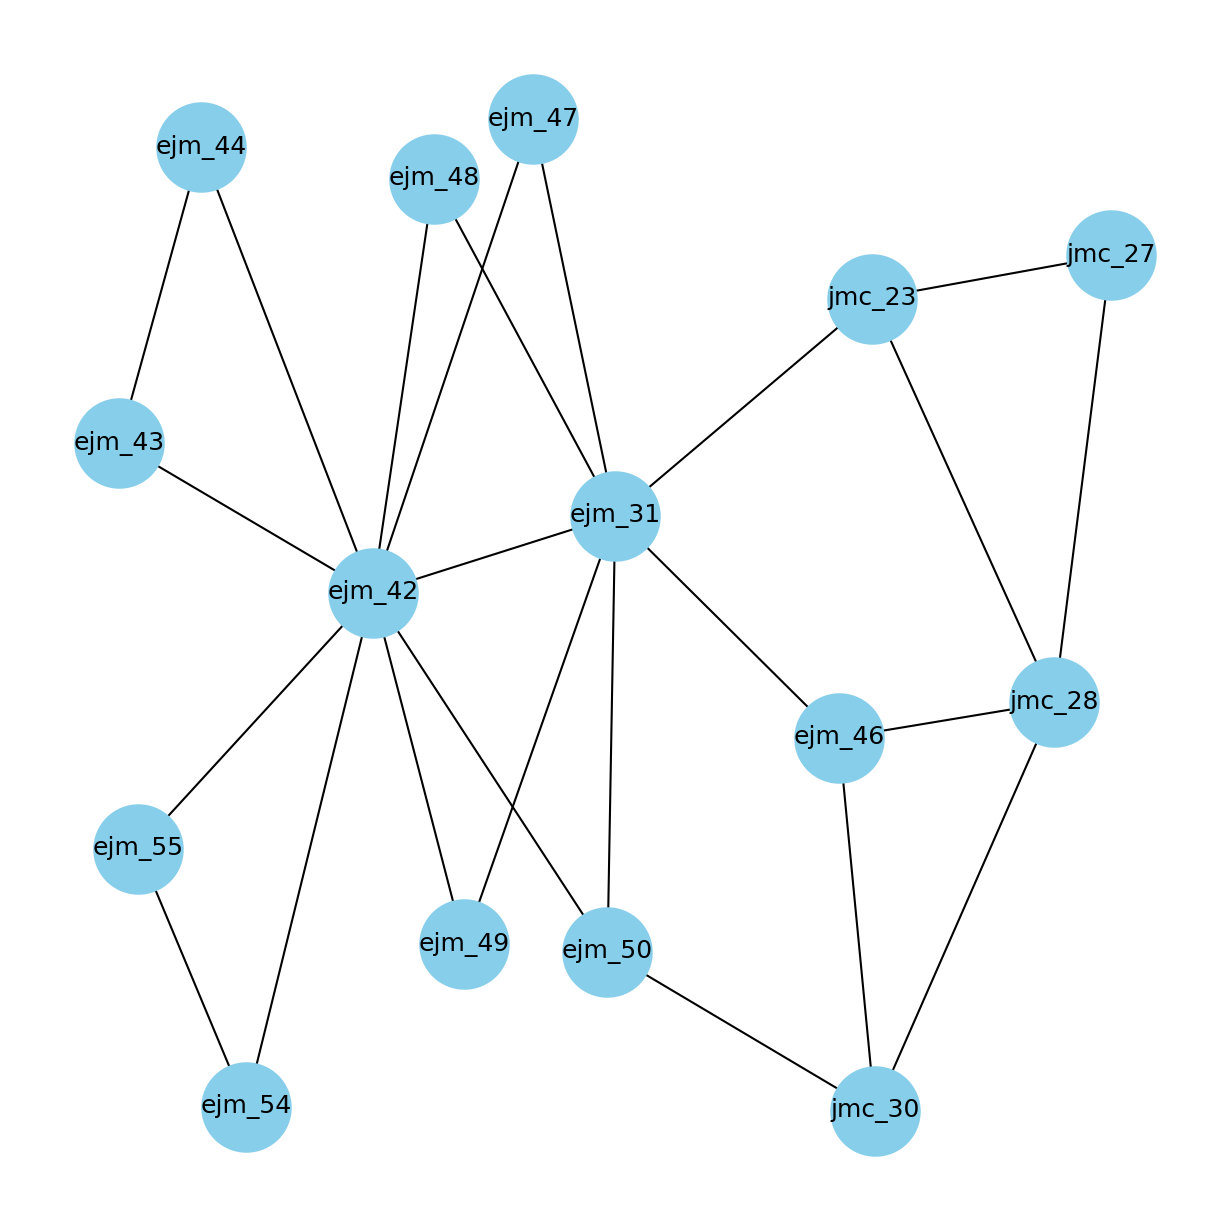

In [3]:
# Generate the graph.
graph = nx.Graph()

# Loop over the nligands and add as nodes to the graph.
for lig in ligands:
    graph.add_node(lig, label=lig, labelloc="t")

# Loop over the edges in the dictionary and add to the graph.
for edge in perturbations:
    lig_0 = edge.split("~")[0]
    lig_1 = edge.split("~")[1]
    graph.add_edge(lig_0, lig_1)

# Plot the networkX graph.
pos = nx.kamada_kawai_layout(graph)
plt.figure(figsize=(8,8), dpi=150)
nx.draw(
    graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=1800, node_color='skyblue', font_size = 12,
    labels={node: node for node in graph.nodes()})

plt.savefig("analysis/analysis_network.png", dpi=300)
plt.show()

For the network that we are considering, we want to get results files with these perturbations from the overall file that contains the large network results. We do not usually have to do this, but in this case it is neccessary to get the files that we need for analysis later.

In [4]:
results_all_files = []
no_repeats=6
# create a list of the results files
for r in list(range(1, no_repeats+1)):
    file_name = f"analysis/repeat_{r}_tyk2.csv"
    results_all_files.append(file_name)

results_files = []

for file in results_all_files:
    new_file_name = f"analysis/results_{results_all_files.index(file)}.csv"
    with open(new_file_name, "w") as result_file:

        writer = csv.writer(result_file, delimiter=",")
        writer.writerow(["lig_1","lig_2","freenrg","error","engine"])

        for row, index in pd.read_csv(file).iterrows():
            pert = f"{index['lig_1']}~{index['lig_2']}"
            if pert in perturbations:
                writer.writerow([index['lig_1'], index['lig_2'], index['freenrg'], index['error'], index['engine']])    

        results_files.append(new_file_name)

### 1.1 Analysing repeats
<a id="reps"></a>  

For the first analysis, we will look at the reproducibility between different repeats. We will calculate the average and SEM for the computed runs, based on their repeats. Here, we have six repeats for each. The SEM can be useful to see how reproducible the different runs are, and a larger SEM would indicate a perturbation that has poorer convergence between repeats.   

In general, for our analyses, we will create a dictionary of the values. These can then be easily converted into a pandas dataframe for plotting. It is also a good idea to save output csv files, so that these are easily accessible in the future and can be loaded into python/excel again for any other plotting.


In [5]:
# make a dictionary with the results of the files
comp_dict_list = {}

# append for results file
for res_file in results_files:
    res_df = pd.read_csv(res_file)
    for index,row in res_df.iterrows():
        lig_0 = row[0]
        lig_1 = row[1]
        pert = f"{lig_0}~{lig_1}"
        # if not comp_dict_list[pert]:
        #     print("oop")
        ddG = row[2]

        if pert in comp_dict_list:
            # Key exist in dict, check if is a list
            if not isinstance(comp_dict_list[pert], list):
                # If type is not list then make it list
                comp_dict_list[pert] = [comp_dict_list[pert]]
            # Append the value in list
            comp_dict_list[pert].append(ddG)
        else:
            # As key is not in dict,
            # so, add key-value pair
            comp_dict_list[pert] = ddG

# now calculate all the avg and SEM for the network perturbations
# put these into a dictionary
comp_diff_dict = {}

# write these to a csv file
with open("analysis/computed_perturbations_average.csv", "w") as comp_pert_file:
    writer = csv.writer(comp_pert_file, delimiter=",")
    writer.writerow(["lig_1","lig_2","freenrg","error","engine"])
    for pert in perturbations:
        ddGs = comp_dict_list[pert]
        lig_0 = pert.split("~")[0]
        lig_1 = pert.split("~")[1]
        comp_ddG = np.average(ddGs)
        comp_err = sem(ddGs)

        #update the dictionary for plotting later
        comp_diff_dict.update({pert:(comp_ddG, comp_err)})

        writer.writerow([lig_0, lig_1, comp_ddG, comp_err, engine])


### 1.2 Experimental binding affinities

Next, we want to visualise our results whilst comparing them to experimental values. In this example here, TYK2 has binding affinities in Ki, and can be converted using ΔG = RTlnK . It is important at this stage to make sure that the units match, so they are consequently converted into kcal/mol. We can carry this conversion out like below:

In [23]:
# create a dictionary for the experimental values
exper_val_dict = {}

# set the temperature in Kelvin
temp = 300

with open(exp_filepath, "r") as exp_file:
    for line in exp_file:
        lig = line.split(",")[0]
        if lig != "lig":
            exp_val = line.split(",")[1].strip()
        if exp_val != "value":
            exp_val = float(exp_val)
             # gas constant in kcal per Kelvin per mol, exp val converted into M
            exp_kcal = 0.0019872041*temp*np.log(exp_val/(10^9))
        err = line.split(",")[2].strip()
        if err != "error":
            err = float(err)
            err_kcal = abs((err/exp_val) * exp_kcal) # TODO CHECK THIS
            exper_val_dict.update({lig:(exp_kcal, err_kcal)})


{'ejm_31': (-2.051998504988738, 0.6198745483820146),
 'ejm_42': (-2.2937210825605847, 0.6809484463851736),
 'ejm_43': (-0.7588927830403923, 0.22586094733345008),
 'ejm_44': (0.09189865889115453, 0.026256759683187008),
 'ejm_45': (-2.0645497313118115, 0.6149722603907524),
 'ejm_46': (-3.837937941941382, 1.1193985663995698),
 'ejm_47': (-2.2071691969978167, 0.6561854369452969),
 'ejm_48': (-1.5057414952370418, 0.45172244857111254),
 'ejm_49': (-0.2417225775718463, 0.07251677327155388),
 'ejm_50': (-1.4814050047727936, 0.44442150143183806),
 'ejm_54': (-3.0499583546178397, 0.9149875063853521),
 'ejm_55': (-1.7113220236985176, 0.5133966071095551),
 'jmc_23': (-4.226828927210783, 1.268048678163235),
 'jmc_27': (-3.8017958928310116, 1.1181752625973564),
 'jmc_28': (-3.4972614606511616, 1.069750564434473),
 'jmc_30': (-3.456598346419195, 1.0255841247617392)}

In [24]:
# now that we have our dictionary, 
# we can also create a dictionary with all the experimental values for the perturbations
exper_diff_dict = {}

# calculate the experimental RBFEs
# write these to a csv file
with open("analysis/experimental_perturbations.csv", "w") as exp_pert_file:
    writer = csv.writer(exp_pert_file, delimiter=",")
    writer.writerow(["lig_1","lig_2","freenrg","error","engine"])

    for pert in perturbations:
        lig_0 = pert.split("~")[0]
        lig_1 = pert.split("~")[1]
        exper_ddG = exper_val_dict[lig_1][0] - exper_val_dict[lig_0][0]
        exper_err = math.sqrt(math.pow(exper_val_dict[lig_0][1], 2) + math.pow(exper_val_dict[lig_1][1], 2))
        exper_diff_dict.update({pert:(exper_ddG, exper_err)})

        writer.writerow([lig_0, lig_1, exper_ddG, exper_err, "experimental"])

### 1.3 Plotting
<a id="plot"></a>

Now we have our computational and experimental in dicitonary format, we can turn this into a pandas dataframe. For plotting it is typically easier to work with the pandas library, which is why this next piece of code will reshape it to this.   

Note that if pandas returns value errors at this step, it is likely there are ligands missing from either your FEP outputs or your experimental input. If a single repeat of a perturbation is missing, the code should be able to deal with this, but if a whole perturbation from the network file is missing there should be an error.


In [25]:
freenrg_pert_dict = {}

# construct dict with experimental freenrg and error and computed
for pert in perturbations:
    exp_ddG = exper_diff_dict[pert][0]
    exp_err = exper_diff_dict[pert][1]
    comp_ddG = comp_diff_dict[pert][0]
    comp_err = comp_diff_dict[pert][1]
    freenrg_pert_dict[pert] = [exp_ddG, exp_err, comp_ddG, comp_err]

# want to put these in a joint dictionary so can convert into pandas df
freenrg_df_pert = pd.DataFrame(freenrg_pert_dict, index=["freenrg_exp", "err_exp", "freenrg_fep", "err_fep"]).transpose()

# save our results to a file that can be opened in e.g. Excel.
freenrg_df_pert.to_csv("analysis/fep_diff_results_table.csv")

Now, we can plot our results against the experimental data. This is best done using a scatter plot:

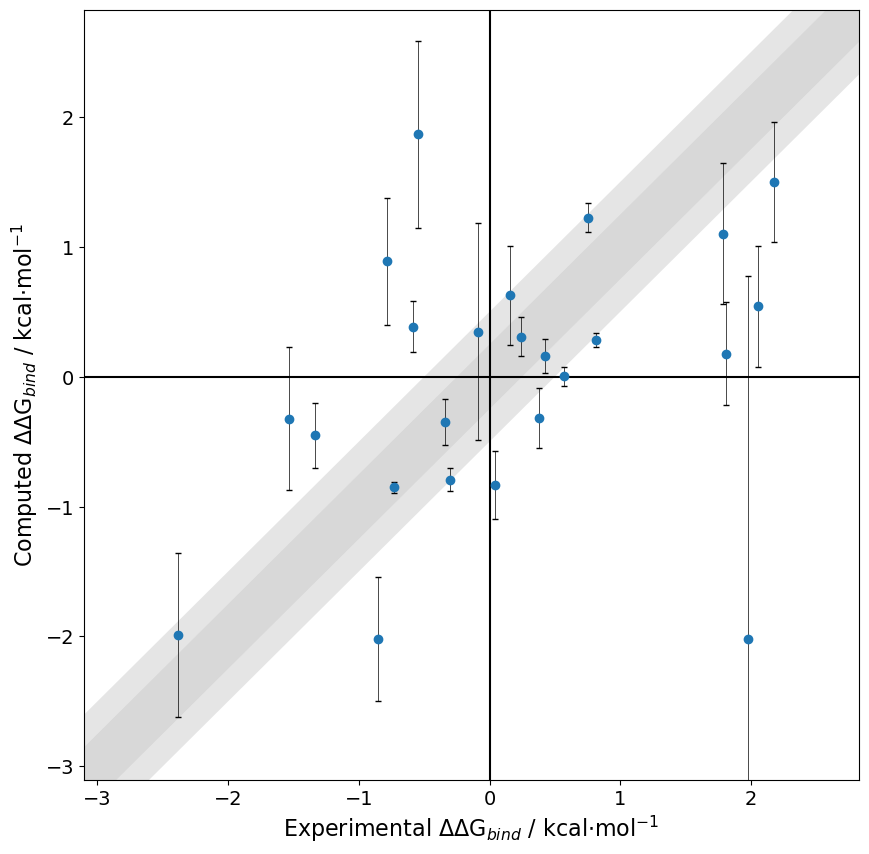

In [30]:
# plot a scatter plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10,10))

# get these based on which column the data is in.
x = freenrg_df_pert["freenrg_exp"]
y = freenrg_df_pert["freenrg_fep"]
x_er = freenrg_df_pert["err_exp"]
y_er = freenrg_df_pert["err_fep"]

# plotting the scatterplot
scatterplot = [plt.scatter(x, y, zorder=10)]

#plotting error bars
plt.errorbar(x , y,
            yerr=y_er,
            # xerr=x_er,   # comment this line to hide experimental error bars \
                        # as this can sometimes overcrowd the plot.
            ls="none",
            lw=0.5, 
            capsize=2,
            color="black",
            zorder=5
            )

# plot 1/2 kcal bounds:
plt.fill_between(
                x=[-100, 100], 
                y2=[-100.25,99.75],
                y1=[-99.75, 100.25],
                lw=0, 
                zorder=-10,
                alpha=0.3,
                color="grey")
# upper bound:
plt.fill_between(
                x=[-100, 100], 
                y2=[-99.5,100.5],
                y1=[-99.75, 100.25],
                lw=0, 
                zorder=-10,
                color="grey", 
                alpha=0.2)
# lower bound:
plt.fill_between(
                x=[-100, 100], 
                y2=[-100.25,99.75],
                y1=[-100.5, 99.5],
                lw=0, 
                zorder=-10,
                color="grey", 
                alpha=0.2)

# get the bounds. This can be done with min/max or simply by hand.
all_freenrg_values = np.concatenate([freenrg_df_pert["freenrg_exp"].values,freenrg_df_pert["freenrg_fep"].values])
min_lim = min(all_freenrg_values)   
max_lim = max(all_freenrg_values)

# for a scatterplot we want the axis ranges to be the same. 
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

plt.axhline(color="black", zorder=1)
plt.axvline(color="black", zorder=1)

plt.ylabel("Computed $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xlabel("Experimental $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

plt.savefig("analysis/fep_vs_exp_scatterplot.png", dpi=300)
plt.show()

This is a very simple way to initially visualise our results. Below, we will consider more rigorous methods for analysis.

## 2. Analysing per Ligand
<a id="lig"></a>


### 2.1 Cinnabar

In this section of the tutorial, we will be using [cinnabar](https://github.com/OpenFreeEnergy/cinnabar) to analyse our results.

First, we have to get our data into a format that can be read by the cinnabar package.

In [40]:
file_name = "analysis/test"

# write these to a csv file
with open(f"{file_name}.csv", "w") as cinnabar_data_file:
    writer = csv.writer(cinnabar_data_file, delimiter=",")

    # first, write the experimental data
    writer.writerow(["# Experimental block"])
    writer.writerow(["# Ligand","expt_DDG","expt_dDDG"])

    for lig in ligands:
        # check if have experimental value
        if lig in exper_val_dict.keys():
            writer.writerow([lig,f"{exper_val_dict[lig][0]}",f"{exper_val_dict[lig][1]}"])


    # second write the perturbation data
    writer.writerow([""])
    writer.writerow(["# Calculated block"])
    writer.writerow(["# Ligand1","Ligand2","calc_DDG","calc_dDDG(MBAR)", "calc_dDDG(additional)"])

    for file in results_files:
        with open(file, "r") as res_file:
            for line in res_file:
                if "lig" in line.split(",")[0]:
                    pass
                else:
                    lig_0 = line.split(",")[0]
                    lig_1 = line.split(",")[1]
                    comp_ddG = line.split(",")[2]
                    comp_err = line.split(",")[3]
        
                    writer.writerow([lig_0, lig_1, comp_ddG, comp_err, "0.0"])

In [3]:
network = wrangle.FEMap("analysis/test.csv")


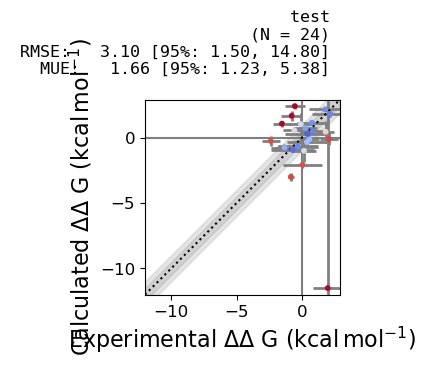

In [4]:
plotting.plot_DDGs(network.graph, title="test", filename=f"analysis/DDGs.png")

In [5]:
network.check_weakly_connected()

True

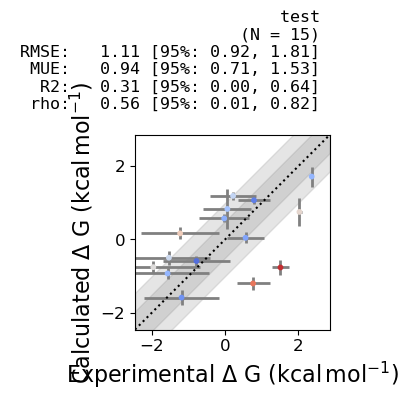

In [5]:
plotting.plot_DGs(network.graph, title="test", filename=f"analysis/DGs.png")

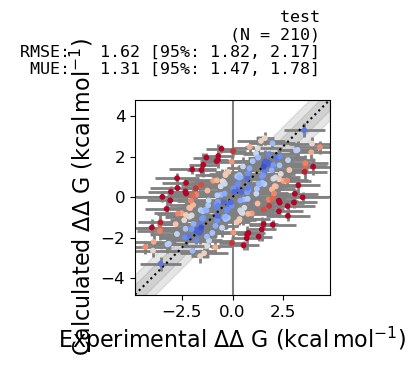

In [7]:
plotting.plot_all_DDGs(network.graph, title="test", filename=f"analysis/all_DDGs.png")


### 2.1. Freenrgworkflows
<a id="fwf"></a>

Below, we will use [FreeNrgWorkFlows](https://github.com/michellab/freenrgworkflows) to analyse the same network. This is an older package that works well with SOMD input, however it is not available as a conda install and is no longer being actively maintained. A copy of the repository for this analysis is included in the `fep_archiv`, and this is what we will be using here. Instead of just computing ΔΔG values for each transformation, we would like to estimate the ΔΔG value for each individual ligand. There are some involved algorithms needed for these steps which is what FreeNrgWorkFlows takes care of for us.     

Let's import this package below:


In [7]:
# import from path for freenrgworkflows.
sys.path.insert(1, '../fep_archiv/freenrgworkflows/networkanalysis/')
import networkanalysis
import experiments
import stats

### 2.1.1 Experimental binding affinities with FreeNrgWorkFlows
<a id="exp"></a>

Earlier, we converted the experimental values we had ourselves. However, we can carry out this conversion using the Freenrgworkflows library, and then use the results.

In [8]:
experiments = experiments.ExperimentalData()
experiments.compute_affinities(exp_filepath, data_type="IC50", comments="#", delimiter=",")
experimental_DDGs = experiments.freeEnergiesInKcal

In [9]:
experimental_DDGs 

[{'ejm_31': 0.2039392865712465, 'error': 0.029},
 {'ejm_42': -0.037783291000599795, 'error': 0.019},
 {'ejm_43': 1.497045008519593, 'error': 0.25},
 {'ejm_44': 2.3478364504511395, 'error': 1.0},
 {'ejm_45': 0.19138806024817342, 'error': 0.028},
 {'ejm_46': -1.582000150381397, 'error': 0.0014},
 {'ejm_47': 0.04876859456216817, 'error': 0.022},
 {'ejm_48': 0.7501962963229429, 'error': 0.072},
 {'ejm_49': 2.014215213988139, 'error': 0.6},
 {'ejm_50': 0.7745327867871915, 'error': 0.075},
 {'ejm_54': -0.7940205630578545, 'error': 0.0054},
 {'ejm_55': 0.5446157678614674, 'error': 0.051},
 {'jmc_23': -1.9708911356507977, 'error': 0.00075},
 {'jmc_27': -1.5458581012710262, 'error': 0.0015},
 {'jmc_28': -1.2413236690911762, 'error': 0.0026},
 {'jmc_30': -1.2006605548592106, 'error': 0.0027}]

Next, we will analyse our network using the `NetworkAnalyser()` and add all our data in. 

In [ ]:
nA = networkanalysis.NetworkAnalyser()

first_file = False
for file_name in results_files:
    if first_file is False:
        nA.read_perturbations_pandas(file_name, comments='#')
        first_file = True
    else:
        # add more replicates to the graph. FreeNrgWorkflows will take care of averaging 
        # the free energies as well as propagating the error.
        nA.add_data_to_graph_pandas(file_name)

computed_relative_DDGs = nA.freeEnergyInKcal

In [ ]:
computed_relative_DDGs

After this, we can load in the experimental data. We already calculated these earlier using Freenrgworkflows as `experimental_ddGs`, so now we can add these directly for our analysis.   

If we have added any intermediate ligands (such as the setup, where we included the intermediate_H), we also want to define the regular expression here. Ligands containing this pattern will be excluded from calculations that compare to experimental values.

In [ ]:
freenrg_dict = {}

intermediate_string=""

# construct dict with experimental freenrg and error.
for ligand in exper_val_dict:
    # only consider the values for the ligands in this network
    if ligand in ligands:
        freenrg = exper_val_dict[ligand][0]
        error = exper_val_dict[ligand][1]
        freenrg_dict[ligand] = [freenrg, error]

# append computed freenrg and error.
for item in computed_relative_DDGs:
        ligand = list(item.keys())[0]
        freenrg = list(item.values())[0]
        error = list(item.values())[1]
                
        if intermediate_string is not ligand:
            freenrg_dict[ligand].append(freenrg)
            freenrg_dict[ligand].append(error)

freenrg_df = pd.DataFrame(freenrg_dict, index=["freenrg_exp", "err_exp", "freenrg_fep", "err_fep"]).transpose()

# save our results to a file that can be opened in e.g. Excel.
freenrg_df.to_csv("analysis/fep_results_table_per_ligand.csv")

### 2.2. Plotting
<a id="plot2"></a>

We can also plot a scatter plot for the ΔΔG per ligand below in a similar manner to how we plotted the perturbations before.

In [ ]:
plt.figure(figsize=(7,7))

plt.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=10)

# plot 1/2 kcal bounds:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				alpha=0.3,
				color="grey")
# upper bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-99.5,100.5],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)
# lower bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-100.5, 99.5],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)

# plot error bars:
yerr = freenrg_df["err_fep"]
xerr = freenrg_df["err_exp"]

plt.errorbar(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], 
            yerr=yerr,
            xerr=xerr,   # comment this line to hide experimental error bars \
                         # as this can sometimes overcrowd the plot.
            ls="none",
            lw=0.5, 
            capsize=2,
            color="black",
            zorder=5
            )

# format the plot further.
plt.axhline(color="black", zorder=1)
plt.axvline(color="black", zorder=1)
plt.ylabel("Predicted $\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xlabel("Experimental $\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

# get the bounds. This can be done with min/max or simply by hand.
all_freenrg_values = np.concatenate([freenrg_df["freenrg_exp"].values,freenrg_df["freenrg_fep"].values])
min_lim = min(all_freenrg_values)
max_lim = max(all_freenrg_values)

# for a scatterplot we want the axis ranges to be the same. 
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

plt.savefig("analysis/fep_vs_exp_scatterplot_per_ligand.png", dpi=300)
plt.show()

Additionally, we can also plot a bar graph for the ΔΔG per ligand.

In [ ]:
# initiate an empty figure with fixed dimensions.
fig, ax = plt.subplots(figsize=(10,5))

# determine positions for X axis labels.
x_locs = np.arange(len(freenrg_df))

# set bar width
width = 0.35  

# plot both our experimental and FEP free energies using an offset on the x position so bars don't overlap.
ax.bar(x_locs - width/2, height=freenrg_df["freenrg_exp"], width=width, yerr=freenrg_df["err_exp"],
                label='Experimental')
ax.bar(x_locs + width/2, height=freenrg_df["freenrg_fep"], width=width, yerr=freenrg_df["err_fep"],
                label='FEP')
 
# format the plot further.
plt.axhline(color="black")
plt.ylabel("$\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xticks(x_locs, freenrg_df.index, rotation=70, ha="right")
plt.legend()

plt.savefig("analysis/fep_vs_exp_barplot_per_ligand.png", dpi=300)
plt.show()

### 2.3. Satistical analysis
<a id="stats"></a>

We also want to carry out a statistical analysis of our results. Below are examples of how to re-sample from the data in order to obtain error bars on correlation coefficients, MUE and Kendall tau. Returned are confidence intervals of 65% and the median of the distribution. It is important to take these confidences into account as FEP predictions have a variance associated with them.

In [ ]:
_stats = stats.freeEnergyStats()
_stats.generate_statistics(computed_relative_DDGs,experimental_DDGs,repeats=10000)
r_confidence = _stats.R_confidence
tau_confidence = _stats.tau_confidence
mue_confidence = _stats.mue_confidence
print ("R confidence is:   %.2f < %.2f < %.2f" %(r_confidence[1], r_confidence[0], r_confidence[2]))
print ("MUE confidence is: %.2f < %.2f < %.2f" %(mue_confidence[1], mue_confidence[0], mue_confidence[2]))
print ("Tau confidence is: %.2f < %.2f < %.2f" %(tau_confidence[1], tau_confidence[0], tau_confidence[2]))

### 2.4. Outliers
<a id="outliers"></a>
As the network analysis performs a weighted least squares regression, a badly computed perturbation can impact the overall quality of our network. Below, we want to annotate any outliers for our perturbations (on the scatter plot) so we can exclude them, rerun  our network analysis, and improve this. We can do this in one of two ways - either we can remove the values that disagree more substantially with the experimental, as below, or, if no experimental values are available, we can consider the error of the perturbation.

First, let's look at our scatter plot with the outlier:

In [ ]:
number_outliers_to_annotate = 1

# get an array of the MUE values comparing experimental and FEP values. Take the absolute values.
mue_values = abs(freenrg_df_pert["freenrg_exp"] - freenrg_df_pert["freenrg_fep"])

# find the n ligand names that are outliers.
outlier_names = mue_values.nlargest(number_outliers_to_annotate).index.values.tolist()
print(outlier_names)

# construct a list of labels to annotate the scatterplot with.
annot_labels = []
colours = []
for ligand in freenrg_df_pert.index.values:
    # if the ligand is an outlier, append the name to the annotation labels list.
    if ligand in outlier_names:
        annot_labels.append(ligand)
        colours.append("red")
    else:
        # if the ligand is not an outlier, append an empty string to the annotation labels list.
        annot_labels.append("")
        colours.append("blue")

# Create the same scatterplot as above. Can include some more of the formatting if needed.
plt.figure(figsize=(7,7))

plt.scatter(freenrg_df_pert["freenrg_exp"], freenrg_df_pert["freenrg_fep"], zorder=10, c=colours)
plt.plot((-10,10),(-10,10))
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

# then, after generating the figure, we can annotate:
for i, txt in enumerate(annot_labels):
    plt.annotate(txt, 
                 (freenrg_df_pert["freenrg_exp"].values.tolist()[i]+0.1,     # x coords
                  freenrg_df_pert["freenrg_fep"].values.tolist()[i]+0.1),    # y coords
                 size=20, color="crimson")

plt.savefig("analysis/fep_vs_exp_outlier_plot.png", dpi=300)
plt.show()

Our largest outlier is 'jmc_30~ejm_50'. Looking at the error below, we can also see that this perturbation has the largest SEM for between the replicates.

In [ ]:
# answer 
error_table = pd.DataFrame(freenrg_df_pert["err_fep"]).sort_values(by="err_fep")

# we can write the table to a csv file that can be opened in e.g. Excel.
error_table.to_csv("analysis/error_table.csv")
error_table

<div class="alert alert-success">
<b>Exercise 2.4.1: Excluding intermediates from the Network analysis</b>
</div>

Try exculding this perturbation and rerunning the above Network analysis. First, we need to remove the perturbation. Then, we need to make sure that our new output image is being saved using a different file path. Adjust these in the cells below where the #FIXME is.   


In [ ]:
# remove the perturbation
# FIXME

<details><summary {style='color:green;font-weight:bold'}> Click here to see solution to Exercise. </summary>

```python
perturbations.remove("jmc_30~ejm_50")
```

</details>

In [ ]:
# below are just copies of the cells we want to rerun:

# rewrite the results files for this network
results_all_files = []
no_repeats=6
# create a list of the results files
for r in list(range(1, no_repeats+1)):
    file_name = f"analysis/repeat_{r}_tyk2.csv"
    results_all_files.append(file_name)

results_files = []

for file in results_all_files:
    new_file_name = f"analysis/results_{results_all_files.index(file)}.csv"  #FIXME
    with open(new_file_name, "w") as result_file:

        writer = csv.writer(result_file, delimiter=",")
        writer.writerow(["lig_1","lig_2","freenrg","error","engine"])

        for row, index in pd.read_csv(file).iterrows():
            pert = f"{index['lig_1']}~{index['lig_2']}"
            if pert in perturbations:
                writer.writerow([index['lig_1'], index['lig_2'], index['freenrg'], index['error'], index['engine']])    

        results_files.append(new_file_name)

# analyse the network again
nA = networkanalysis.NetworkAnalyser()

first_file = False
for file_name in results_files:
    if first_file is False:
        nA.read_perturbations_pandas(file_name, comments='#')
        first_file = True
    else:
        # add more replicates to the graph. FreeNrgWorkflows will take care of averaging 
        # the free energies as well as propagating the error.
        nA.add_data_to_graph_pandas(file_name)

computed_relative_DDGs = nA.freeEnergyInKcal

# make the dictionary for plotting again

freenrg_dict = {}

intermediate_string=" "

# construct dict with experimental freenrg and error.
for ligand in exper_val_dict:
    # only consider the values for the ligands in this network
    if ligand in ligands:
        freenrg = exper_val_dict[ligand][0]
        error = exper_val_dict[ligand][1]
        freenrg_dict[ligand] = [freenrg, error]

# append computed freenrg and error.
for item in computed_relative_DDGs:
        ligand = list(item.keys())[0]
        freenrg = list(item.values())[0]
        error = list(item.values())[1]
                
        if intermediate_string not in ligand:
            freenrg_dict[ligand].append(freenrg)
            freenrg_dict[ligand].append(error)

freenrg_df = pd.DataFrame(freenrg_dict, index=["freenrg_exp", "err_exp", "freenrg_fep", "err_fep"]).transpose()

# save our results to a file that can be opened in e.g. Excel.
freenrg_df.to_csv("analysis/fep_results_table_per_ligand.csv" #FIXME)

<details><summary {style='color:green;font-weight:bold'}> Click here to see solution to Exercise. </summary>

```python
# answer
# below are just copies of the cells we want to rerun:

# rewrite the results files for this network
results_all_files = []
no_repeats=6
# create a list of the results files
for r in list(range(1, no_repeats+1)):
    file_name = f"analysis/repeat_{r}_tyk2.csv"
    results_all_files.append(file_name)

results_files = []

for file in results_all_files:
    new_file_name = f"analysis/results_{results_all_files.index(file)}_excluded_perturbation.csv"
    with open(new_file_name, "w") as result_file:

        writer = csv.writer(result_file, delimiter=",")
        writer.writerow(["lig_1","lig_2","freenrg","error","engine"])

        for row, index in pd.read_csv(file).iterrows():
            pert = f"{index['lig_1']}~{index['lig_2']}"
            if pert in perturbations:
                writer.writerow([index['lig_1'], index['lig_2'], index['freenrg'], index['error'], index['engine']])    

        results_files.append(new_file_name)

# analyse the network again
nA = networkanalysis.NetworkAnalyser()

first_file = False
for file_name in results_files:
    if first_file is False:
        nA.read_perturbations_pandas(file_name, comments='#')
        first_file = True
    else:
        # add more replicates to the graph. FreeNrgWorkflows will take care of averaging 
        # the free energies as well as propagating the error.
        nA.add_data_to_graph_pandas(file_name)

computed_relative_DDGs = nA.freeEnergyInKcal

# make the dictionary for plotting again

freenrg_dict = {}

intermediate_string=" "

# construct dict with experimental freenrg and error.
for ligand in exper_val_dict:
    # only consider the values for the ligands in this network
    if ligand in ligands:
        freenrg = exper_val_dict[ligand][0]
        error = exper_val_dict[ligand][1]
        freenrg_dict[ligand] = [freenrg, error]

# append computed freenrg and error.
for item in computed_relative_DDGs:
        ligand = list(item.keys())[0]
        freenrg = list(item.values())[0]
        error = list(item.values())[1]
                
        if intermediate_string not in ligand:
            freenrg_dict[ligand].append(freenrg)
            freenrg_dict[ligand].append(error)

freenrg_df = pd.DataFrame(freenrg_dict, index=["freenrg_exp", "err_exp", "freenrg_fep", "err_fep"]).transpose()

# save our results to a file that can be opened in e.g. Excel.
freenrg_df.to_csv("analysis/fep_results_table_per_ligand_excluded_perturbation.csv")
```

</details>

In [ ]:
plt.figure(figsize=(7,7))

plt.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=10)

# plot 1/2 kcal bounds:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				alpha=0.3,
				color="grey")
# upper bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-99.5,100.5],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)
# lower bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-100.5, 99.5],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)

# plot error bars:
yerr = freenrg_df["err_fep"]
xerr = freenrg_df["err_exp"]

plt.errorbar(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], 
            yerr=yerr,
            xerr=xerr,   # comment this line to hide experimental error bars \
                         # as this can sometimes overcrowd the plot.
            ls="none",
            lw=0.5, 
            capsize=2,
            color="black",
            zorder=5
            )

# format the plot further.
plt.axhline(color="black", zorder=1)
plt.axvline(color="black", zorder=1)
plt.ylabel("Predicted $\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xlabel("Experimental $\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

# get the bounds. This can be done with min/max or simply by hand.
all_freenrg_values = np.concatenate([freenrg_df["freenrg_exp"].values,freenrg_df["freenrg_fep"].values])
min_lim = min(all_freenrg_values)
max_lim = max(all_freenrg_values)

# for a scatterplot we want the axis ranges to be the same. 
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

plt.savefig("analysis/fep_vs_exp_scatterplot_per_ligand.png"  #FIXME, dpi=300)
plt.show()

<details><summary {style='color:green;font-weight:bold'}> Click here to see solution to Exercise. </summary>

```python
plt.figure(figsize=(7,7))

plt.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=10)

# plot 1/2 kcal bounds:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				alpha=0.3,
				color="grey")
# upper bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-99.5,100.5],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)
# lower bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-100.5, 99.5],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)

# plot error bars:
yerr = freenrg_df["err_fep"]
xerr = freenrg_df["err_exp"]

plt.errorbar(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], 
            yerr=yerr,
            xerr=xerr,   # comment this line to hide experimental error bars \
                         # as this can sometimes overcrowd the plot.
            ls="none",
            lw=0.5, 
            capsize=2,
            color="black",
            zorder=5
            )

# format the plot further.
plt.axhline(color="black", zorder=1)
plt.axvline(color="black", zorder=1)
plt.ylabel("Predicted $\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xlabel("Experimental $\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

# get the bounds. This can be done with min/max or simply by hand.
all_freenrg_values = np.concatenate([freenrg_df["freenrg_exp"].values,freenrg_df["freenrg_fep"].values])
min_lim = min(all_freenrg_values)
max_lim = max(all_freenrg_values)

# for a scatterplot we want the axis ranges to be the same. 
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

plt.savefig("analysis/fep_vs_exp_scatterplot_per_ligand_excluded_perturbation.png", dpi=300)
plt.show()
```

</details>

In [ ]:
# initiate an empty figure with fixed dimensions.
fig, ax = plt.subplots(figsize=(10,5))

# determine positions for X axis labels.
x_locs = np.arange(len(freenrg_df))

# set bar width
width = 0.35  

# plot both our experimental and FEP free energies using an offset on the x position so bars don't overlap.
ax.bar(x_locs - width/2, height=freenrg_df["freenrg_exp"], width=width, yerr=freenrg_df["err_exp"],
                label='Experimental')
ax.bar(x_locs + width/2, height=freenrg_df["freenrg_fep"], width=width, yerr=freenrg_df["err_fep"],
                label='FEP')
 
# format the plot further.
plt.axhline(color="black")
plt.ylabel("$\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xticks(x_locs, freenrg_df.index, rotation=70, ha="right")
plt.legend()

plt.savefig("analysis/fep_vs_exp_barplot_per_ligand.png"  #FIXME, dpi=300)
plt.show()

<details><summary {style='color:green;font-weight:bold'}> Click here to see solution to Exercise. </summary>

```python
# initiate an empty figure with fixed dimensions.
fig, ax = plt.subplots(figsize=(10,5))

# determine positions for X axis labels.
x_locs = np.arange(len(freenrg_df))

# set bar width
width = 0.35  

# plot both our experimental and FEP free energies using an offset on the x position so bars don't overlap.
ax.bar(x_locs - width/2, height=freenrg_df["freenrg_exp"], width=width, yerr=freenrg_df["err_exp"],
                label='Experimental')
ax.bar(x_locs + width/2, height=freenrg_df["freenrg_fep"], width=width, yerr=freenrg_df["err_fep"],
                label='FEP')
 
# format the plot further.
plt.axhline(color="black")
plt.ylabel("$\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xticks(x_locs, freenrg_df.index, rotation=70, ha="right")
plt.legend()

plt.savefig("analysis/fep_vs_exp_barplot_per_ligand_excluded_perturbation.png", dpi=300)
plt.show()
```

</details>

Do these graphs look different from the previous ones? Below we will also rerun our statistical tests. Is our statistical analysis improved?

In [ ]:
_stats = stats.freeEnergyStats()
_stats.generate_statistics(computed_relative_DDGs,experimental_DDGs,repeats=10000)
r_confidence = _stats.R_confidence
tau_confidence = _stats.tau_confidence
mue_confidence = _stats.mue_confidence
print ("R confidence is:   %.2f < %.2f < %.2f" %(r_confidence[1], r_confidence[0], r_confidence[2]))
print ("MUE confidence is: %.2f < %.2f < %.2f" %(mue_confidence[1], mue_confidence[0], mue_confidence[2]))
print ("Tau confidence is: %.2f < %.2f < %.2f" %(tau_confidence[1], tau_confidence[0], tau_confidence[2]))

<details><summary {style='color:green;font-weight:bold'}> Click here to see solution to Exercise. </summary>
        
Yes, our graphs look different.         

Excluding the perturbation should have improved the statistical tests.      
previous output was:        
R confidence is:   -0.25 < -0.22 < -0.18        
MUE confidence is: 1.60 < 1.63 < 1.67       
Tau confidence is: -0.22 < -0.20 < -0.16        
        
the results with the excluded perturbation are:     
R confidence is:   0.49 < 0.52 < 0.56       
MUE confidence is: 0.88 < 0.92 < 0.95       
Tau confidence is: 0.30 < 0.33 < 0.37       

Also visually, both the scatter and the bar plot show better agreement with experimental data.      
This is particularly true for example for 'jmc30', where the previous output for the FEP result per ligand was almost the complete opposite of the experimental, whereas now it has no significant difference to the experimental.      
</details>

<div class="alert alert-success">
<b>Exercise 2.4.2: Visualising the ligand</b>
</div>

Based on our results, we may also want to visualise which of our ligands had the highest binding affinity.

**Hint:** First, sort the data frame to find the ligand with the best binding affinity and then use BSS to visualise it like in the introductionary workshop.

In [ ]:
# FIXME

<details><summary {style='color:green;font-weight:bold'}> Click here to see solution to Exercise. </summary>

```python
results_table = pd.DataFrame(freenrg_df["freenrg_fep"]).sort_values(by="freenrg_fep")

results_table.to_csv("analysis/fep_predictions_excluded_perturbation.csv")
results_table

BSS.Notebook.View("inputs/ligands/ejm44.sdf").system()

```
</details>

This notebook has covered the basics of some analysis that can be done on our RBFE results. There are many ways to customise this, and it is also a good idea to check out the further reading for a good overview of FEP data reporting best practices: [Section 8.7, LiveComs Best Practices for Alchemical Free Energy Calculations](https://livecomsjournal.org/index.php/livecoms/article/view/v2i1e18378).

As for the setup workshop, all the generated graphs and tables outputs are available in the 'example_output' folder.
